In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
import pickle

# Loading the training data
file_path_train = '/content/drive/My Drive/Colab Notebooks/ChatBot/train_qa.txt'
with open(file_path_train, 'rb') as file:
    train_data = pickle.load(file)
print(len(train_data))


10000


In [4]:
# Loading the testing data
file_path_test = '/content/drive/My Drive/Colab Notebooks/ChatBot/test_qa.txt'
with open(file_path_test, 'rb') as file:
    test_data = pickle.load(file)
print(len(test_data))

1000


In [5]:
def see_data(data, n):
    story = ' '.join(data[n][0])
    question = ' '.join(data[n][1])
    answer = data[n][2]
    print(f"Story: {story}")
    print(f"Query: {question}")
    print(f"Answer: {answer}")

In [6]:
see_data(train_data, 0)
see_data(train_data, 1)
see_data(train_data, 2)
see_data(train_data, 3)

Story: Mary moved to the bathroom . Sandra journeyed to the bedroom .
Query: Is Sandra in the hallway ?
Answer: no
Story: Mary moved to the bathroom . Sandra journeyed to the bedroom . Mary went back to the bedroom . Daniel went back to the hallway .
Query: Is Daniel in the bathroom ?
Answer: no
Story: Mary moved to the bathroom . Sandra journeyed to the bedroom . Mary went back to the bedroom . Daniel went back to the hallway . Sandra went to the kitchen . Daniel went back to the bathroom .
Query: Is Daniel in the office ?
Answer: no
Story: Mary moved to the bathroom . Sandra journeyed to the bedroom . Mary went back to the bedroom . Daniel went back to the hallway . Sandra went to the kitchen . Daniel went back to the bathroom . Daniel picked up the football there . Daniel went to the bedroom .
Query: Is Daniel in the bedroom ?
Answer: yes


In [7]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import numpy as np

In [8]:
# Combine all data for tokenization
all_data = [item for sublist in train_data + test_data for item in sublist]
tokenizer = Tokenizer()
tokenizer.fit_on_texts(all_data)

vocab_size = len(tokenizer.word_index) + 1
max_story_len = max(map(len, (x for x, _, _ in train_data + test_data)))
max_question_len = max(map(len, (x for _, x, _ in train_data + test_data)))
print(f"Vocab Size: {vocab_size}")
print(f"Max Story Length: {max_story_len}")
print(f"Max Question Length: {max_question_len}")

Vocab Size: 38
Max Story Length: 156
Max Question Length: 6


In [9]:
def vectorize_stories(data, tokenizer, max_story_len, max_question_len, vocab_size):
    X_stories = []
    X_questions = []
    Y_answers = []

    for story, question, answer in data:
        story_seq = tokenizer.texts_to_sequences([story])[0]
        question_seq = tokenizer.texts_to_sequences([question])[0]

        # One-hot encode the answer
        answer_seq = np.zeros(vocab_size)
        answer_index = tokenizer.word_index[answer]
        answer_seq[answer_index] = 1

        X_stories.append(story_seq)
        X_questions.append(question_seq)
        Y_answers.append(answer_seq)

    return pad_sequences(X_stories, maxlen=max_story_len), pad_sequences(X_questions, maxlen=max_question_len), np.array(Y_answers)


In [10]:

X_story_train, X_question_train, Y_answer_train = vectorize_stories(train_data, tokenizer, max_story_len, max_question_len, vocab_size)
X_story_test, X_question_test, Y_answer_test = vectorize_stories(test_data, tokenizer, max_story_len, max_question_len, vocab_size)


In [11]:
print(max_story_len)
print(max_question_len)
print(len(X_story_train[0]))
print(len(X_question_train[0]))
print(len(Y_answer_train[0]))
print(len(X_story_test[0]))
print(len(X_question_test[0]))
print(len(Y_answer_test[0]))

156
6
156
6
38
156
6
38


In [12]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Embedding, Dropout, dot, Activation, add, Permute, concatenate, SimpleRNN, Dense
from tensorflow.keras.models import Model


In [13]:
# Inputs
input_sequence = Input((max_story_len,))
question = Input((max_question_len,))
embed_size = 100



In [14]:
# Encoding layers
M = Embedding(input_dim=vocab_size, output_dim=embed_size)(input_sequence)
C = Embedding(input_dim=vocab_size, output_dim=max_question_len)(input_sequence)
question_encoder = Embedding(input_dim=vocab_size, output_dim=embed_size, input_length=max_question_len)(question)


In [15]:
# Operations
matcho = dot([M, question_encoder], axes=-1)
matcho = Activation('softmax')(matcho)
a_ = add([matcho])
a_ = Permute((2, 1))(a_)
answers = concatenate([a_, question_encoder])


In [16]:

# Final layers
answers = SimpleRNN(50)(answers)
answers = Dropout(0.3)(answers)
answers = Dense(vocab_size)(answers)
answers = Activation('softmax')(answers)


In [17]:

# Model
model = Model(inputs=[input_sequence, question], outputs=answers)
model.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

history = model.fit([X_story_train, X_question_train], Y_answer_train, epochs=50, validation_data=([X_story_test, X_question_test], Y_answer_test))

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 156)]                0         []                            
                                                                                                  
 input_2 (InputLayer)        [(None, 6)]                  0         []                            
                                                                                                  
 embedding (Embedding)       (None, 156, 100)             3800      ['input_1[0][0]']             
                                                                                                  
 embedding_2 (Embedding)     (None, 6, 100)               3800      ['input_2[0][0]']             
                                                                                              

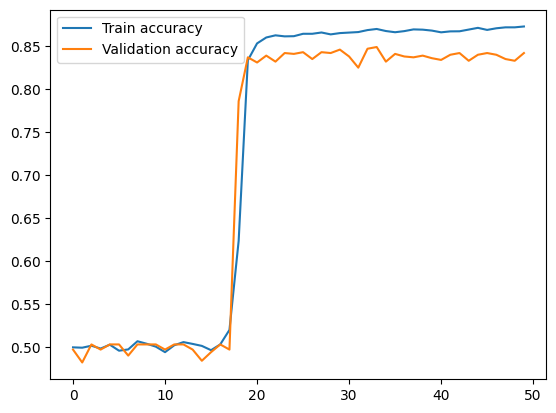

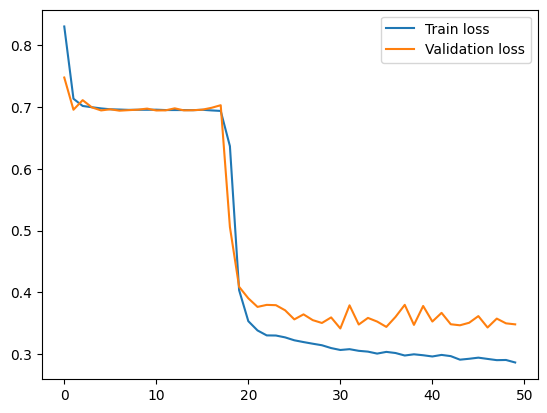

In [18]:
import matplotlib.pyplot as plt

plt.plot(history.history['accuracy'], label="Train accuracy")
plt.plot(history.history['val_accuracy'], label="Validation accuracy")
plt.legend()
plt.show()

plt.plot(history.history['loss'], label="Train loss")
plt.plot(history.history['val_loss'], label="Validation loss")
plt.legend()
plt.show()

In [19]:
predictions = model.predict([X_story_test, X_question_test])

for i in range(10):
    story = ' '.join(test_data[i][0])
    question = ' '.join(test_data[i][1])
    print(f"Story: {story}")
    print(f"Question: {question}")
    print(f"Original Answer: {test_data[i][2]}")
    index = np.argmax(predictions[i])
    for word, idx in tokenizer.word_index.items():
        if idx == index:
            print(f"Predicted Answer: {word}")
            print("-----------------------------------------------------------------------------------------")


32/32 [==============================] - 1s 7ms/step
Story: Mary got the milk there . John moved to the bedroom .
Question: Is John in the kitchen ?
Original Answer: no
Predicted Answer: no
-----------------------------------------------------------------------------------------
Story: Mary got the milk there . John moved to the bedroom . Mary discarded the milk . John went to the garden .
Question: Is John in the kitchen ?
Original Answer: no
Predicted Answer: no
-----------------------------------------------------------------------------------------
Story: Mary got the milk there . John moved to the bedroom . Mary discarded the milk . John went to the garden . Daniel moved to the bedroom . Daniel went to the garden .
Question: Is John in the garden ?
Original Answer: yes
Predicted Answer: yes
-----------------------------------------------------------------------------------------
Story: Mary got the milk there . John moved to the bedroom . Mary discarded the milk . John went to the

In [20]:
# Evaluate the model on the test set
test_accuracy = model.evaluate([X_story_test, X_question_test], Y_answer_test)
print(f"Test Accuracy: {test_accuracy}")


32/32 [==============================] - 0s 8ms/step - loss: 0.3484 - accuracy: 0.8420
Test Accuracy: [0.34839534759521484, 0.8420000076293945]


In [21]:
from sklearn.metrics import confusion_matrix, classification_report
import numpy as np

# Predict on the test set
predictions = model.predict([X_story_test, X_question_test])

# Convert predictions and true labels from one-hot encoded format to class labels
y_pred = np.argmax(predictions, axis=1)
y_true = np.argmax(Y_answer_test, axis=1)

# Compute confusion matrix
conf_matrix = confusion_matrix(y_true, y_pred)
print("Confusion Matrix:")
print(conf_matrix)


32/32 [==============================] - 0s 6ms/step
Confusion Matrix:
[[457  40]
 [118 385]]
